In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15
from util_tsne_exact import FUNCTION_NAMES, sum_operations_by_measure, sum_operations, sum_operations_by_function

# Euler

### System Information

Compiler:
```
icc 16.0.0
```

CPU: **Intel Xeon E3-1285Lv5 Skylake 3.00 GHz**

Cache:
* L1: 32 KB
* L2: 256 KB
* L3: 8 MB

Memory bandwidth: 34.1 GB/s (theoretical)

## Final Benchmark

In [22]:
iters_baseline = pd.read_csv("./baseline/20170528_135608@iters.csv")
cycles_baseline = pd.read_csv("./baseline/20170528_135608@cycles.csv")
iters_avx = pd.read_csv("./avx/20170528_140123@iters.csv")
cycles_avx = pd.read_csv("./avx/20170528_140123@cycles.csv")
iters_scalar = pd.read_csv("./scalar/20170528_140123@iters.csv")
cycles_scalar = pd.read_csv("./scalar/20170528_140123@cycles.csv")
N = iters_baseline["N"]

In [23]:
def get_flops(N, it, D=28*28, d=2, T=1000):
    count_measure = ("add", "mult", "div", "exp", "log")
    flops = {
        "normalize": {
            "add": 2 * N * D,
            "div": D + N * D
        },
        "compute_pairwise_affinity_perplexity": {
            "compute_squared_euclidean_distance": {
                "add": D * N * (N - 1) / 2 * 2,
                "mult": D * N * (N - 1) / 2
            },
            "binary_search": {
                "add": it * (N + N + 1 + 1),
                "mult": it * (N + 2 * N),
                "div": it * (1 + 1) + N * N,
                "exp": it * N,
                "log": it * (1 + 1)
            }
        },
        "symmetrize_affinities": {
            "add": N * (N - 1) / 2 + N * N,
            "div": N * N
        },
        "early_exageration": {
            "mult": 2 * N * N
        },
        "compute_low_dimensional_affinities": {
            "compute_squared_euclidean_distance": {
                "add": T * d * N * (N - 1) / 2 * 2,
                "mult": T * d * N * (N - 1) / 2
            },
            "compute": {
                "add": T * N * (N - 1) * 2,
                "div": T * N * (N - 1)
            }
        },
        "gradient_computation": {
            "add": T * N * (N - 1) * (1 + 2 * d),
            "mult": T * N * (N - 1) * (1 + d),
            "div": T * N * (N - 1)
        },
        "gradient_update": {
            "add": T * (N * d + N * d * 2),
            "mult": T * N * d * 3
        },
        "normalize_2": {
            "add": T * 2 * N * d,
            "div": T * (d + N * d)
        }
    }

    flops_by_function_measure = dict(flops)
    flops_by_function_measure["compute_pairwise_affinity_perplexity"] = \
        sum_operations_by_measure(flops["compute_pairwise_affinity_perplexity"])
    flops_by_function_measure["compute_low_dimensional_affinities"] = \
        sum_operations_by_measure(flops["compute_low_dimensional_affinities"])
    flops_by_function = sum_operations_by_function(
        flops_by_function_measure, size=N.shape[0])

    total_flops = sum_operations_by_measure(flops_by_function_measure)
    total_flops = sum_operations(total_flops)
    return total_flops

In [73]:
flops_baseline = get_flops(N, iters_baseline[" cycles"])
flops_avx = get_flops(N, iters_avx[" cycles"])
flops_scalar = get_flops(N, iters_scalar[" cycles"])
perf_baseline = flops_baseline/cycles_baseline["total"]
perf_scalar = flops_scalar/cycles_scalar["total"]
perf_avx = flops_avx/cycles_avx["total"]

In [ ]:
mpl.rcParams['figure.figsize'] = (8.1, 5)
title = "Overall Performance MNIST D = 784"
ylabel = "flops/cycle"
legend = False
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

base, = ax.plot(N, perf_baseline, linewidth=lw, marker=marker, markersize=markersize, label="Baseline")
scalar, = ax.plot(N, perf_scalar, linewidth=lw, marker=marker, markersize=markersize, label="Baseline")
avx, = ax.plot(N, perf_avx, linewidth=lw, marker=marker, markersize=markersize, label="Baseline")

ax.text(3000, 2.8, "Baseline", color=base.get_color())
ax.text(3000, 2.8, "Best Scalar", color=scalar.get_color())
ax.text(3000, 2.8, "Best AVX", color=avx.get_color())

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))

plt.show()

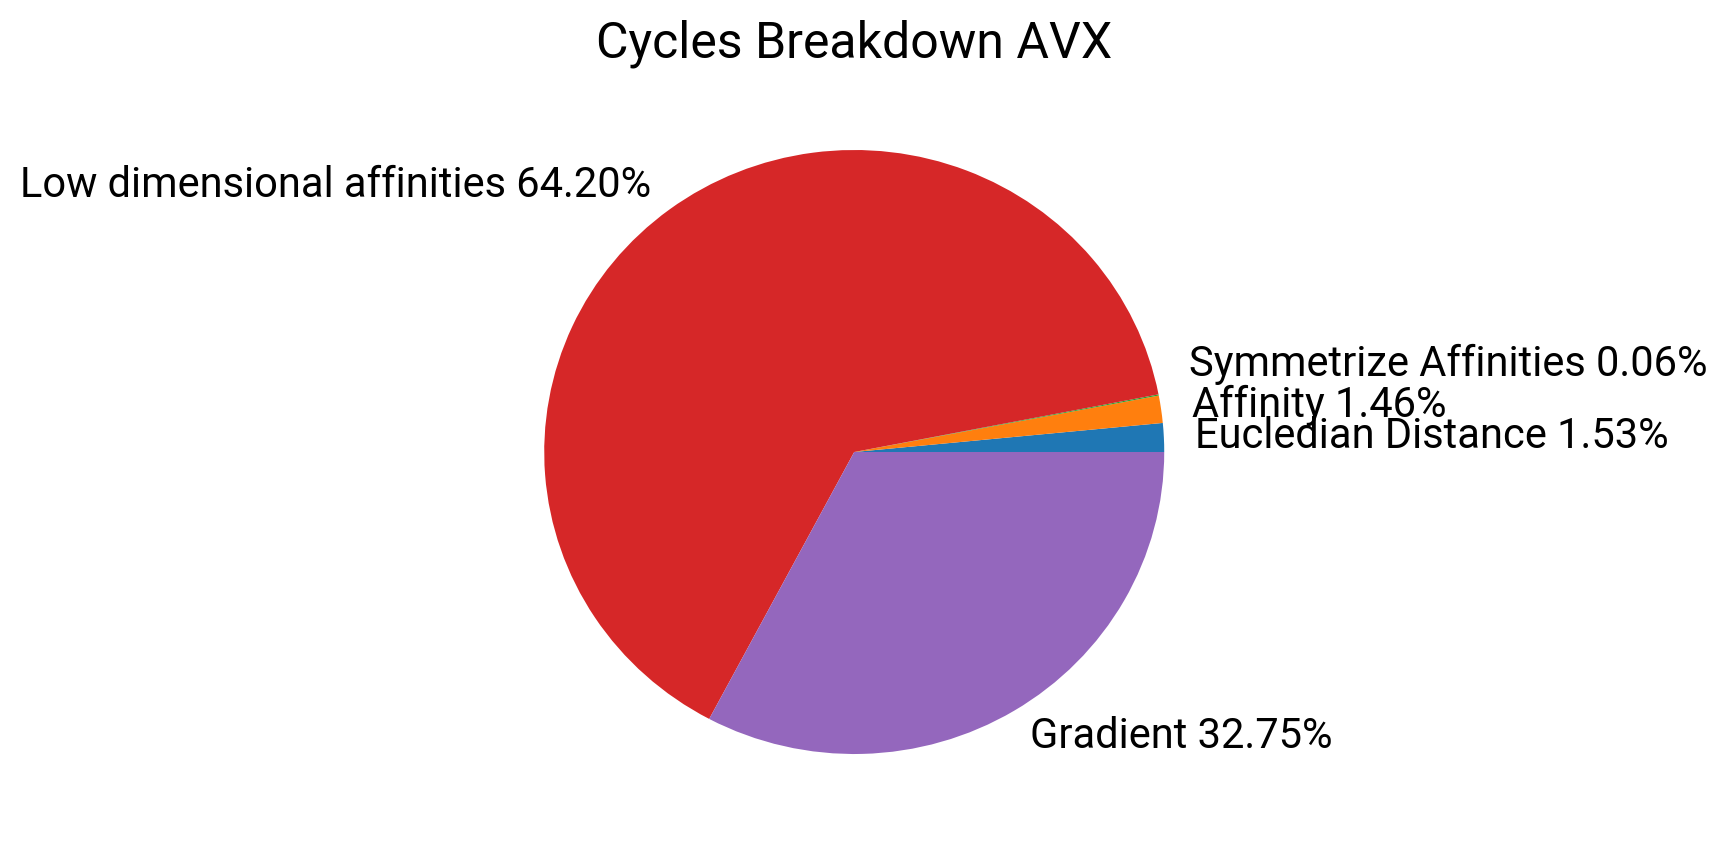

In [105]:
mpl.rcParams['figure.figsize'] = (5, 5)
funcs = list(cycles_avx.columns.values)[1:-1]
split = []
for f in funcs:
    split.append(cycles_avx[f].as_matrix()[-1]/cycles_avx["total"].as_matrix()[-1])
disp_names = ["Eucledian Distance", "Affinity", "Symmetrize Affinities", "Low dimensional affinities", "Gradient"]
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown AVX")
(x,y) = t[2].get_position()
t[2].set_position( (x,y*1.4) )
plt.show()

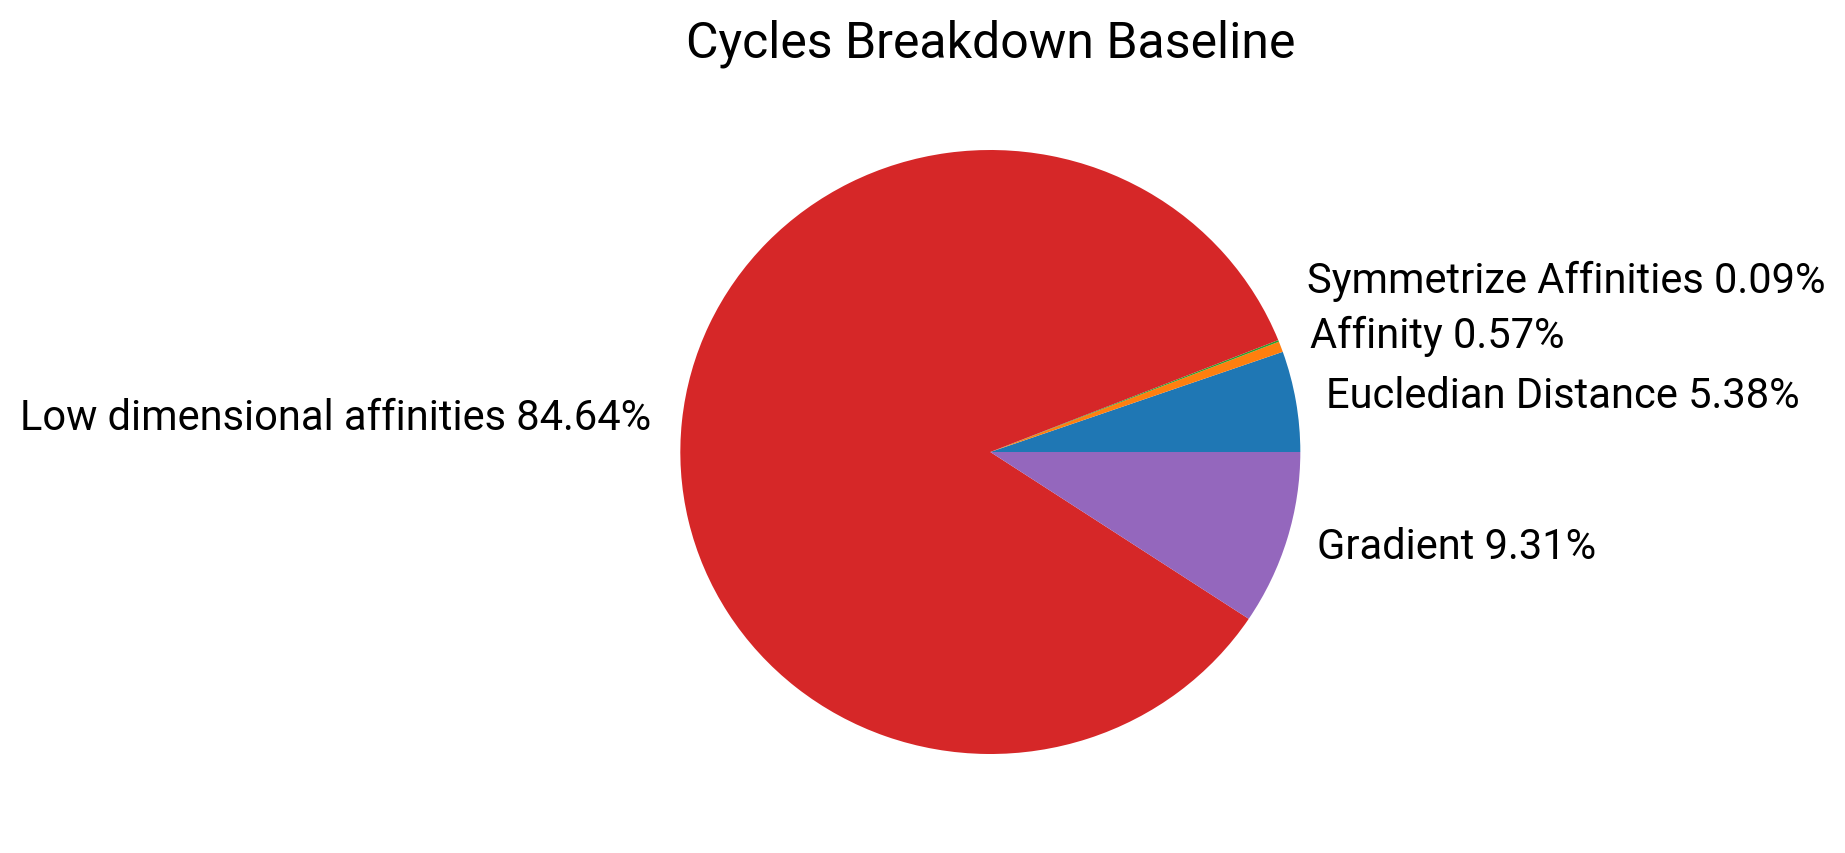

In [106]:
mpl.rcParams['figure.figsize'] = (5, 5)
funcs = list(cycles_baseline.columns.values)[1:-1]
split = []
for f in funcs:
    split.append(cycles_baseline[f].as_matrix()[-1]/cycles_baseline["total"].as_matrix()[-1])
disp_names = ["Eucledian Distance", "Affinity", "Symmetrize Affinities", "Low dimensional affinities", "Gradient"]
for i in range(len(split)):
    disp_names[i] = disp_names[i] + " " + "%.2f"%(100*split[i]) + "%"
_, t = plt.pie(split, labels = disp_names)
plt.title("Cycles Breakdown Baseline")
(x,y) = t[2].get_position()
t[2].set_position( (x,y*1.4) )
plt.show()

pairwise_squared_euclidean_distance 0.0538137103548
pairwise_affinity_perplexity 0.00569047631995
symmetrize_affinities 0.000931984577066
low_dimensional_affinities 0.846417591936
gradient_computation_update_normalize 0.0931462368117
